# DAGAN_PyTorch

## Introduction
This is a re-implementation code in PyTorch by Jiahao Huang for [DAGAN: Deep De-Aliasing Generative Adversarial Networks for Fast Compressed Sensing MRI Reconstruction](https://ieeexplore.ieee.org/document/8233175/) published in IEEE Transactions on Medical Imaging (2018).
[Guang Yang](https://www.imperial.ac.uk/people/g.yang)\, [Simiao Yu](https://nebulav.github.io/)\, et al.
(* equal contributions)

Official code : [DAGAN](https://github.com/tensorlayer/DAGAN).
If you use this code for your research, please cite our paper.

```
@article{yang2018_dagan,
	author = {Yang, Guang and Yu, Simiao and Dong, Hao and Slabaugh, Gregory G. and Dragotti, Pier Luigi and Ye, Xujiong and Liu, Fangde and Arridge, Simon R. and Keegan, Jennifer and Guo, Yike and Firmin, David N.},
	journal = {IEEE Trans. Med. Imaging},
	number = 6,
	pages = {1310--1321},
	title = {{DAGAN: deep de-aliasing generative adversarial networks for fast compressed sensing MRI reconstruction}},
	volume = 37,
	year = 2018
}
```

If you have any questions about this code, please feel free to contact Jiahao Huang (huangjiahao0711@gmail.com).

## Prerequisites
The original code is in python 3.6 under the following dependencies:
1. torch (v1.7.0+cu101)
2. torchvision (v0.8.0)
2. tensorlayer (v1.7.2)
3. easydict (v1.9)
4. nibabel (v2.1.0)
5. scikit-image (v0.17.2)

The Code tested in Windows10 with Nvidia GPU + CUDA(10.1) CuDNN (v7.6.0.64)

## Data

1. Prepare data

    Put
    testing.pickle
    training.pickle
    validation.pickle

    into data/MICCAI13_SegChallenge/

In [1]:
%matplotlib inline

In [2]:
import os
from pickle import load
from time import localtime, strftime, time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
from torch.utils import data
import torchvision.models as models
import torchvision.utils as vutils
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import loadmat
import scipy.fftpack
import skimage.measure

from easydict import EasyDict as edict


In [3]:
# information of device
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device Info.:{}'.format(device))

Device Info.:cuda


In [4]:
# parameter
# 'unet, unet_refine'
model_name = 'unet'
# 'gaussian1d, gaussian2d, poisson2d'
mask_name = 'gaussian2d'
# '10,20,30,40,50'
mask_perc = 30
print("unet model:{}".format(model_name))
print("mask:{}_{}".format(mask_name,mask_perc))

unet model:unet
mask:gaussian2d_30


In [5]:
# basic config
config = edict()
config.TRAIN = edict()
config.TEST = edict()
config.VAL = edict()

config.TRAIN.batch_size = 7
config.TRAIN.early_stopping_num = 5
config.TRAIN.save_every_epoch = 2
config.TRAIN.save_img_every_val_step = 5
config.TRAIN.lr = 0.0001  # init learning rate
config.TRAIN.lr_decay = 0.5  # learning rate decay rate
config.TRAIN.lr_decay_every = 5  # decay every epoch
config.TRAIN.beta1 = 0.5  # beta1 in Adam optimiser
config.TRAIN.n_epoch = 20  # total epoch

config.TRAIN.is_mini_dataset = False  # for debug
config.TRAIN.size_mini_trainset = 20
config.TRAIN.size_mini_valset = 20
config.TEST.size_mini_dataset = 300

config.TRAIN.g_alpha = 15  # weight for pixel loss
config.TRAIN.g_gamma = 0.0025  # weight for perceptual loss
config.TRAIN.g_beta = 0.1  # weight for frequency loss
config.TRAIN.g_adv = 1  # weight for adv loss

config.TRAIN.VGG16_path = os.path.join('trained_model', 'VGG16', 'vgg16_weights.npz')
config.TRAIN.training_data_path = os.path.join('data', 'MICCAI13_SegChallenge', 'training.pickle')
config.TRAIN.val_data_path = os.path.join('data', 'MICCAI13_SegChallenge', 'validation.pickle')
config.TRAIN.mask_Gaussian1D_path = os.path.join('mask', 'Gaussian1D')
config.TRAIN.mask_Gaussian2D_path = os.path.join('mask', 'Gaussian2D')
config.TRAIN.mask_Poisson2D_path = os.path.join('mask', 'Poisson2D')

config.TEST.VGG16_path = os.path.join('trained_model', 'VGG16', 'vgg16_weights.npz')
config.TEST.testing_data_path = os.path.join('data', 'MICCAI13_SegChallenge', 'testing.pickle')
config.TEST.mask_Gaussian1D_path = os.path.join('mask', 'Gaussian1D')
config.TEST.mask_Gaussian2D_path = os.path.join('mask', 'Gaussian2D')
config.TEST.mask_Poisson2D_path = os.path.join('mask', 'Poisson2D')

config.TEST.train_date = '2020_11_18_16_07_46'
# config.TEST.weight_unet = 'best_checkpoint_generator_unet_gaussian2d_30_epoch_1_nmse_0.1069742100579398.pt'

In [6]:
# current time
current_time = strftime("%Y_%m_%d_%H_%M_%S", localtime())
print("current_time:{}".format(current_time))

current_time:2020_11_19_17_10_46


In [7]:
# setup checkpoint directory
checkpoint_dir = os.path.join("checkpoint_{}_{}_{}"
                              .format(model_name, mask_name, mask_perc),
                              current_time)
isExists = os.path.exists(checkpoint_dir)
if not isExists:
    os.makedirs(os.path.join(checkpoint_dir))
print("checkpoint_dir:{}".format(checkpoint_dir))

checkpoint_dir:checkpoint_unet_gaussian2d_30\2020_11_19_17_10_46


In [8]:
# configs
batch_size = config.TRAIN.batch_size
early_stopping_num = config.TRAIN.early_stopping_num
save_epoch_every = config.TRAIN.save_every_epoch
save_img_every_val_step = config.TRAIN.save_img_every_val_step
g_alpha = config.TRAIN.g_alpha
g_beta = config.TRAIN.g_beta
g_gamma = config.TRAIN.g_gamma
g_adv = config.TRAIN.g_adv
lr = config.TRAIN.lr
lr_decay = config.TRAIN.lr_decay
lr_decay_every = config.TRAIN.lr_decay_every
beta1 = config.TRAIN.beta1
n_epoch = config.TRAIN.n_epoch
is_mini_dataset = config.TRAIN.is_mini_dataset
size_mini_trainset = config.TRAIN.size_mini_trainset
size_mini_valset = config.TRAIN.size_mini_valset
size_mini_testset = config.TEST.size_mini_dataset

train_date = config.TEST.train_date
# weight_unet = config.TEST.weight_unet

In [9]:
# define filtering
def to_bad_img(x, mask):
    y = x.copy()
    for i in range(x.shape[0]):
        xx = x[i, :, :, 0]
        xx = (xx + 1.) / 2.
        fft = scipy.fftpack.fft2(xx)
        fft = scipy.fftpack.fftshift(fft)
        fft = fft * mask
        fft = scipy.fftpack.ifftshift(fft)
        xx = scipy.fftpack.ifft2(fft)
        xx = np.abs(xx)
        xx = xx * 2 - 1
        y[i, :, :, :] = xx[:, :, np.newaxis]
    return y

In [10]:
# define fourier transform
def fft_abs_for_map_fn(x):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = torch.div(torch.add(x, torch.ones_like(x)), 2)
    fft_x = torch.fft.fftn(x)
    fft_abs = torch.abs(fft_x)

    return fft_abs

In [11]:
# define structural similarity
def ssim(x_good, x_bad):
    x_good = np.squeeze(x_good.numpy())
    x_bad = np.squeeze(x_bad.numpy())
    ssim_res = []
    for idx in range(x_good.shape[0]):
        ssim_res.append(skimage.measure.compare_ssim(x_good[idx], x_bad[idx]))

    return ssim_res

In [12]:
# defien peak signal to noise ratio
def psnr(x_good, x_bad):
    x_good = np.squeeze(x_good.numpy())
    x_bad = np.squeeze(x_bad.numpy())
    psnr_res = []
    for idx in range(x_good.shape[0]):
        psnr_res.append(skimage.measure.compare_psnr(x_good[idx], x_bad[idx]))

    return psnr_res

In [13]:
# data path
training_data_path = config.TRAIN.training_data_path
val_data_path = config.TRAIN.val_data_path
testing_data_path = config.TEST.testing_data_path
print('training dataset path:{}'.format(training_data_path))
print('validation dataset path:{}'.format(val_data_path))
print('testing dataset path:{}'.format(testing_data_path))

training dataset path:data\MICCAI13_SegChallenge\training.pickle
validation dataset path:data\MICCAI13_SegChallenge\validation.pickle
testing dataset path:data\MICCAI13_SegChallenge\testing.pickle


In [14]:
# define date augment
class DataAugment:
    def __init__(self):
        self.transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(0)
        ])

    def __call__(self, x):
        x = torch.div(torch.add(x, torch.ones_like(x)), 2)
        x = self.transform_train(x)
        x = torch.sub(torch.mul(x, 2), torch.ones_like(x))

        return x

In [15]:
# date augment
data_augment = DataAugment()

In [16]:
# load data
with open(training_data_path, 'rb') as f:
    X_train = torch.from_numpy(load(f))
    if is_mini_dataset:
        X_train = X_train[0:size_mini_trainset]
    X_train = data_augment(X_train)
with open(val_data_path, 'rb') as f:
    X_val = torch.from_numpy(load(f))
    if is_mini_dataset:
        X_val = X_val[0:size_mini_valset]
with open(testing_data_path, 'rb') as f:
    X_test = torch.from_numpy(load(f))
    if is_mini_dataset:
        X_test = X_test[0:size_mini_testset]

log = 'X_train shape:{}/ min:{}/ max:{}\n'.format(X_train.shape, X_train.min(), X_train.max()) \
      + 'X_val shape:{}/ min:{}/ max:{}\n'.format(X_val.shape, X_val.min(), X_val.max()) \
      + 'X_test shape:{}/ min:{}/ max:{}'.format(X_test.shape, X_test.min(), X_test.max())
print(log)

C:\Users\H\.conda\envs\DAGAN_PyTorch\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


X_train shape:torch.Size([20, 256, 256, 1])/ min:-1.0/ max:0.18156325817108154
X_val shape:torch.Size([20, 256, 256, 1])/ min:-1.0/ max:0.8805273771286011
X_test shape:torch.Size([300, 256, 256, 1])/ min:-1.0/ max:1.0


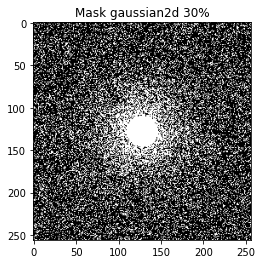

In [17]:
# load mask
if mask_name == "gaussian2d":
    mask = \
        loadmat(
            os.path.join(config.TRAIN.mask_Gaussian2D_path, "GaussianDistribution2DMask_{}.mat".format(mask_perc)))[
            'maskRS2']
elif mask_name == "gaussian1d":
    mask = \
        loadmat(
            os.path.join(config.TRAIN.mask_Gaussian1D_path, "GaussianDistribution1DMask_{}.mat".format(mask_perc)))[
            'maskRS1']
elif mask_name == "poisson2d":
    mask = \
        loadmat(
            os.path.join(config.TRAIN.mask_Gaussian1D_path, "PoissonDistributionMask_{}.mat".format(mask_perc)))[
            'population_matrix']
else:
    raise ValueError("no such mask exists: {}".format(mask_name))
plt.title("Mask {} {}%".format(mask_name,mask_perc))
plt.imshow(mask, cmap ='gray')

In [18]:
# data loader
dataloader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, pin_memory=True, timeout=0,
                                         shuffle=True)
dataloader_val = torch.utils.data.DataLoader(X_val, batch_size=batch_size, pin_memory=True, timeout=0,
                                             shuffle=True)
dataloader_test = torch.utils.data.DataLoader(X_test, batch_size=batch_size, pin_memory=True, timeout=0,
                                              shuffle=True)

In [19]:
# define early stopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=10, model_name='unet', mask_name='gaussian2d', mask_perc=30,
                 verbose=False, delta=0, checkpoint_path='./checkpoint_dir', trace_func=print):

        self.patience = patience
        self.model_name = model_name
        self.mask_name = mask_name
        self.mask_perc = mask_perc
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.nmse = None
        self.early_stop = False
        self.val_nmse_min = np.Inf
        self.weight_unet = '.'
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.trace_func = trace_func

    def __call__(self, nmse, model_g, model_d, epoch):

        # nmse(+ --> 0) score(- --> 0)
        score = -nmse
        # init score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(nmse, model_g, model_d, epoch)
        # new model is worse
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        # new model is better
        else:
            self.best_score = score
            self.save_checkpoint(nmse, model_g, model_d, epoch)
            self.counter = 0

        log = f'EarlyStopping counter of epoch {epoch + 1} : {self.counter} out of {self.patience}'
        print(log)

    def save_checkpoint(self, val_nmse, model_g, model_d, epoch):
        # save model when validation loss decrease.
        if self.verbose:
            log = f'Validation loss decreased ({self.val_nmse_min:.6f} --> {val_nmse:.6f}).  Saving model ...'
            print(log)

        # update the min nmse
        self.val_nmse_min = val_nmse
        self.weight_unet = "best_checkpoint_generator_{}_{}_{}_epoch_{}_nmse_{}.pt"\
            .format(self.model_name, self.mask_name, self.mask_perc, epoch + 1, self.val_nmse_min)
        torch.save(model_g.state_dict(),
                   os.path.join(self.checkpoint_path,
                                "best_checkpoint_generator_{}_{}_{}_epoch_{}_nmse_{}.pt"
                                .format(self.model_name, self.mask_name, self.mask_perc, epoch + 1, self.val_nmse_min)))
        torch.save(model_d.state_dict(),
                   os.path.join(self.checkpoint_path,
                                "best_checkpoint_discriminator_{}_{}_{}_epoch_{}_nmse_{}.pt"
                                .format(self.model_name, self.mask_name, self.mask_perc, epoch + 1, self.val_nmse_min)))
    def get_best_weight(self):
        return self.weight_unet

In [20]:
# early stopping
early_stopping = EarlyStopping(early_stopping_num,
                               model_name=model_name, mask_name=mask_name, mask_perc=mask_perc,
                               verbose=True, checkpoint_path=checkpoint_dir)

In [21]:
# define pre-processing for vgg
class VGG_PRE:
    def __init__(self):
        self.transform_vgg = transforms.Compose([transforms.Resize((244, 244))])
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def __call__(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = torch.mul(torch.add(x, torch.ones_like(x)), 127.5)
        mean = torch.from_numpy(np.array([123.68, 116.779, 103.939], dtype=np.float32)
                                .reshape((1, 3, 1, 1)))
        x = torch.sub(x, mean.to(self.device))
        x = self.transform_vgg(x)

        return x

In [22]:
# pre-processing for vgg
vgg_pre = VGG_PRE()

In [23]:
# define vgg
class VGG_CNN(nn.Module):
    def __init__(self):
        super(VGG_CNN, self).__init__()

        # load vgg16
        self.vgg16 = models.vgg16(pretrained=True)
        # get conv4
        self.vgg16_cnn = nn.Sequential(*list(self.vgg16.features.children())[:-7])

    def forward(self, x):
        return self.vgg16_cnn(x)

In [24]:
# load vgg
vgg16_cnn = VGG_CNN()
vgg16_cnn = vgg16_cnn.to(device)

In [25]:
# define generator(unet)
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # set parameter
        self.gf_dim = 64
        self.kernel_size = 4
        self.padding = 1

        # network
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.gf_dim, kernel_size=self.kernel_size, stride=2,
                      padding=self.padding),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=self.gf_dim, out_channels=self.gf_dim * 2, kernel_size=self.kernel_size, stride=2,
                      padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 2),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=self.gf_dim * 2, out_channels=self.gf_dim * 4, kernel_size=self.kernel_size, stride=2,
                      padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 4),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=self.gf_dim * 4, out_channels=self.gf_dim * 8, kernel_size=self.kernel_size, stride=2,
                      padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 8),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=self.gf_dim * 8, out_channels=self.gf_dim * 8, kernel_size=self.kernel_size, stride=2,
                      padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 8),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=self.gf_dim * 8, out_channels=self.gf_dim * 8, kernel_size=self.kernel_size, stride=2,
                      padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 8),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=self.gf_dim * 8, out_channels=self.gf_dim * 8, kernel_size=self.kernel_size, stride=2,
                      padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 8),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=self.gf_dim * 8, out_channels=self.gf_dim * 8, kernel_size=self.kernel_size, stride=2,
                      padding=self.padding),
            nn.LeakyReLU(negative_slope=0.2)  # 源代码又LReLu 论文框架没有
        )

        self.deconv7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.gf_dim * 8, out_channels=self.gf_dim * 8, kernel_size=self.kernel_size,
                               stride=2, padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 8),
            nn.ReLU()
        )

        self.deconv6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.gf_dim * 16, out_channels=self.gf_dim * 16,
                               kernel_size=self.kernel_size, stride=2, padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 16),
            nn.ReLU()
        )

        self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.gf_dim * 24, out_channels=self.gf_dim * 16,
                               kernel_size=self.kernel_size, stride=2, padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 16),
            nn.ReLU()
        )

        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.gf_dim * 24, out_channels=self.gf_dim * 16,
                               kernel_size=self.kernel_size, stride=2, padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 16),
            nn.ReLU()
        )

        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.gf_dim * 24, out_channels=self.gf_dim * 4, kernel_size=self.kernel_size,
                               stride=2, padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 4),
            nn.ReLU()
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.gf_dim * 8, out_channels=self.gf_dim * 2, kernel_size=self.kernel_size,
                               stride=2, padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim * 2),
            nn.ReLU()
        )

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.gf_dim * 4, out_channels=self.gf_dim, kernel_size=self.kernel_size,
                               stride=2, padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim),
            nn.ReLU()
        )

        self.deconv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.gf_dim * 2, out_channels=self.gf_dim, kernel_size=self.kernel_size,
                               stride=2, padding=self.padding),
            nn.BatchNorm2d(num_features=self.gf_dim),
            nn.ReLU()
        )

        self.out = nn.Sequential(
            nn.Conv2d(in_channels=self.gf_dim, out_channels=1, kernel_size=1, stride=1, padding=0),
            nn.Tanh(),
        )

        self.refine = nn.Tanh()

    # forward propagation
    def forward(self, x, is_refine=False):
        input = x
        down1 = self.conv1(input)
        down2 = self.conv2(down1)
        down3 = self.conv3(down2)
        down4 = self.conv4(down3)
        down5 = self.conv5(down4)
        down6 = self.conv6(down5)
        down7 = self.conv7(down6)
        down8 = self.conv8(down7)
        up7 = self.deconv7(down8)
        up6 = self.deconv6(torch.cat((down7, up7), 1))
        up5 = self.deconv5(torch.cat((down6, up6), 1))
        up4 = self.deconv4(torch.cat((down5, up5), 1))
        up3 = self.deconv3(torch.cat((down4, up4), 1))
        up2 = self.deconv2(torch.cat((down3, up3), 1))
        up1 = self.deconv1(torch.cat((down2, up2), 1))
        up0 = self.deconv0(torch.cat((down1, up1), 1))
        output = self.out(up0)

        if is_refine:
            output = self.refine(output + input)

        return output

In [26]:
# load generator(unet)
generator = UNet()
generator = generator.to(device)

In [27]:
# define discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # set parameter
        self.df_dim = 64
        self.fin = 8192

        # network
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.df_dim, kernel_size=5, stride=2, padding=2, ),
            nn.LeakyReLU(negative_slope=0.2)

        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=self.df_dim, out_channels=self.df_dim * 2, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=self.df_dim * 2),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=self.df_dim * 2, out_channels=self.df_dim * 4, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=self.df_dim * 4),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=self.df_dim * 4, out_channels=self.df_dim * 8, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=self.df_dim * 8),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=self.df_dim * 8, out_channels=self.df_dim * 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=self.df_dim * 16),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=self.df_dim * 16, out_channels=self.df_dim * 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=self.df_dim * 32),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=self.df_dim * 32, out_channels=self.df_dim * 16, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=self.df_dim * 16),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=self.df_dim * 16, out_channels=self.df_dim * 8, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=self.df_dim * 8),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.res8 = nn.Sequential(
            nn.Conv2d(in_channels=self.df_dim * 8, out_channels=self.df_dim * 2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=self.df_dim * 2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=self.df_dim * 2, out_channels=self.df_dim * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=self.df_dim * 2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=self.df_dim * 2, out_channels=self.df_dim * 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=self.df_dim * 8),
        )

        self.LRelu = nn.LeakyReLU(negative_slope=0.2)

        self.out = nn.Sequential(
            nn.Linear(self.fin, 1),
            nn.Sigmoid()
        )

    # forward propagation
    def forward(self, input_image):
        net_in = input_image
        net_h0 = self.conv0(net_in)
        net_h1 = self.conv1(net_h0)
        net_h2 = self.conv2(net_h1)
        net_h3 = self.conv3(net_h2)
        net_h4 = self.conv4(net_h3)
        net_h5 = self.conv5(net_h4)
        net_h6 = self.conv6(net_h5)
        net_h7 = self.conv7(net_h6)
        res_h7 = self.res8(net_h7)
        net_h8 = self.LRelu(res_h7 + net_h7)
        net_ho = net_h8.contiguous().view(net_h8.size(0), -1)
        logits = self.out(net_ho)

        return logits

In [28]:
# load discriminator
discriminator = Discriminator()
discriminator = discriminator.to(device)

In [29]:
# loss function
bce = nn.BCELoss(reduction='mean').to(device)
mse = nn.MSELoss(reduction='mean').to(device)

In [30]:
# real and fake label
real = 1.
fake = 0.

In [31]:
# optimizer
g_optim = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim.lr_scheduler.StepLR(g_optim, lr_decay_every, gamma=lr_decay, last_epoch=-1)

d_optim = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optim.lr_scheduler.StepLR(d_optim, lr_decay_every, gamma=lr_decay, last_epoch=-1)

In [32]:
# initialize global variant
GLOBAL_STEP = 0
G_LOSS = []
D_LOSS = []
NMSE_training = []
SSIM_training = []
PSNR_training = []
NMSE_validation = []
SSIM_validation = []
PSNR_validation = []

In [33]:
# train loop
for epoch in range(0, n_epoch):
    # initialize training
    total_nmse_training = 0
    total_ssim_training = 0
    total_psnr_training = 0
    num_training_temp = 0

    # training
    for step, X_good in enumerate(dataloader):

        # starting time for step
        step_time = time()

        # good-->bad
        X_bad = torch.from_numpy(to_bad_img(X_good.numpy(), mask))

        # cpu-->gpu
        X_good = X_good.to(device)
        X_bad = X_bad.to(device)

        # (N, H, W, C)-->(N, C, H, W)
        X_good = X_good.permute(0, 3, 1, 2)
        X_bad = X_bad.permute(0, 3, 1, 2)

        # generator
        if model_name == 'unet':
            X_generated = generator(X_bad, is_refine=False)
        elif model_name == 'unet_refine':
            X_generated = generator(X_bad, is_refine=True)
        else:
            raise Exception("unknown model")

        # discriminator
        logits_fake = discriminator(X_generated)
        logits_real = discriminator(X_good)

        # vgg
        X_good_244 = vgg_pre(X_good)
        net_vgg_conv4_good = vgg16_cnn(X_good_244)
        X_generated_244 = vgg_pre(X_generated)
        net_vgg_conv4_gen = vgg16_cnn(X_generated_244)

        # discriminator loss
        d_loss_real = bce(logits_real, torch.full((logits_real.size()), real).to(device))
        d_loss_fake = bce(logits_fake, torch.full((logits_fake.size()), fake).to(device))

        d_loss = d_loss_real + d_loss_fake

        # generator loss (adversarial)
        g_adversarial = bce(logits_fake, torch.full((logits_fake.size()), real).to(device))

        # generator loss (perceptual)
        g_perceptual = mse(net_vgg_conv4_good, net_vgg_conv4_gen)

        # generator loss (pixel-wise)
        g_nmse_a = mse(X_generated, X_good)
        g_nmse_b = mse(X_generated, torch.zeros_like(X_generated).to(device))
        g_nmse = torch.div(g_nmse_a, g_nmse_b)

        # generator loss (frequency)
        g_fft = mse(fft_abs_for_map_fn(X_generated), fft_abs_for_map_fn(X_good))

        # generator loss (total)
        g_loss = g_adv * g_adversarial + g_alpha * g_nmse + g_gamma * g_perceptual + g_beta * g_fft

        # clear gradient (discriminator)
        d_optim.zero_grad()
        # back propagation (discriminator)
        d_loss.backward(retain_graph=True)

        # clear gradient (generator)
        g_optim.zero_grad()
        # back propagation (generator)
        g_loss.backward()

        # update weight
        d_optim.step()
        g_optim.step()

        with torch.no_grad():

            # training loss
            G_LOSS.append(g_loss.item())
            D_LOSS.append(d_loss.item())

            log = "Epoch[{:3}/{:3}] step={:3} d_loss={:5} g_loss={:5}  took {:3}s".format(
                epoch + 1, n_epoch, step,
                round(float(d_loss), 3),
                round(float(g_loss), 3),
                round(time() - step_time, 2))
            if step % 1 == 0:
                print(log)

            # gpu --> cpu
            X_good = X_good.cpu()
            X_generated = X_generated.cpu()
            X_bad = X_bad.cpu()

            # (-1,1)-->(0,1)
            X_good_0_1 = torch.div(torch.add(X_good, torch.ones_like(X_good)), 2)
            X_generated_0_1 = torch.div(torch.add(X_generated, torch.ones_like(X_generated)), 2)
            X_bad_0_1 = torch.div(torch.add(X_bad, torch.ones_like(X_bad)), 2)

            # eval for training
            nmse_a = mse(X_generated_0_1, X_good_0_1)
            nmse_b = mse(X_generated_0_1, torch.zeros_like(X_generated_0_1))
            nmse_res = torch.div(nmse_a, nmse_b).numpy()
            ssim_res = ssim(X_generated_0_1, X_good_0_1)
            psnr_res = psnr(X_generated_0_1, X_good_0_1)

            total_nmse_training = total_nmse_training + np.sum(nmse_res)
            total_ssim_training = total_ssim_training + np.sum(ssim_res)
            total_psnr_training = total_psnr_training + np.sum(psnr_res)

            num_training_temp = num_training_temp + batch_size
            GLOBAL_STEP = GLOBAL_STEP + 1

    total_nmse_training = total_nmse_training / num_training_temp
    total_ssim_training = total_ssim_training / num_training_temp
    total_psnr_training = total_psnr_training / num_training_temp

    # record training eval
    NMSE_training.append(total_nmse_training)
    SSIM_training.append(total_ssim_training)
    PSNR_training.append(total_psnr_training)

    log = "Epoch: {}  NMSE training: {:8}, SSIM training: {:8}, PSNR training: {:8}".format(
        epoch + 1,
        round(total_nmse_training,5),
        round(total_ssim_training,5),
        round(total_psnr_training,5))
    print(log)

    # initialize validation
    total_nmse_val = 0
    total_ssim_val = 0
    total_psnr_val = 0
    num_val_temp = 0

    X_good_val_sample = []
    X_bad_val_sample = []
    X_generated_val_sample = []

    with torch.no_grad():
        # validation
        for step_val, X_good in enumerate(dataloader_val):

            # good-->bad
            X_bad = torch.from_numpy(to_bad_img(X_good.numpy(), mask))

            # cpu-->gpu
            X_good = X_good.to(device)
            X_bad = X_bad.to(device)

            # (N, H, W, C)-->(N, C, H, W)
            X_good = X_good.permute(0, 3, 1, 2)
            X_bad = X_bad.permute(0, 3, 1, 2)

            # generator
            if model_name == 'unet':
                X_generated = generator(X_bad, is_refine=False)
            elif model_name == 'unet_refine':
                X_generated = generator(X_bad, is_refine=True)
            else:
                raise Exception("unknown model")

            # discriminator
            logits_fake = discriminator(X_generated)
            logits_real = discriminator(X_good)

            # vgg
            X_good_244 = vgg_pre(X_good)
            net_vgg_conv4_good = vgg16_cnn(X_good_244)
            X_generated_244 = vgg_pre(X_generated)
            net_vgg_conv4_gen = vgg16_cnn(X_generated_244)

            # gpu --> cpu
            X_good = X_good.cpu()
            X_generated = X_generated.cpu()
            X_bad = X_bad.cpu()

            # (-1,1)-->(0,1)
            X_good_0_1 = torch.div(torch.add(X_good, torch.ones_like(X_good)), 2)
            X_generated_0_1 = torch.div(torch.add(X_generated, torch.ones_like(X_generated)), 2)
            X_bad_0_1 = torch.div(torch.add(X_bad, torch.ones_like(X_bad)), 2)

            # eval for validation
            nmse_a = mse(X_generated_0_1, X_good_0_1)
            nmse_b = mse(X_generated_0_1, torch.zeros_like(X_generated_0_1))
            nmse_res = torch.div(nmse_a, nmse_b).numpy()
            ssim_res = ssim(X_generated_0_1, X_good_0_1)
            psnr_res = psnr(X_generated_0_1, X_good_0_1)

            total_nmse_val = total_nmse_val + np.sum(nmse_res)
            total_ssim_val = total_ssim_val + np.sum(ssim_res)
            total_psnr_val = total_psnr_val + np.sum(psnr_res)

            num_val_temp = num_val_temp + batch_size

        total_nmse_val = total_nmse_val / num_val_temp
        total_ssim_val = total_ssim_val / num_val_temp
        total_psnr_val = total_psnr_val / num_val_temp

        # record training eval
        NMSE_validation.append(total_nmse_training)
        SSIM_validation.append(total_ssim_training)
        PSNR_validation.append(total_psnr_training)

        log = "Epoch: {}  NMSE val: {:8}, SSIM val: {:8}, PSNR val: {:8}".format(
            epoch + 1,
            round(total_nmse_val,5),
            round(total_ssim_val,5),
            round(total_psnr_val,5))
        print(log)

        # # saving checkpoint
        # if (epoch + 1) % save_epoch_every == 0:
        #     torch.save(generator.state_dict(),
        #                os.path.join(checkpoint_dir,
        #                             "checkpoint_generator_{}_{}_{}_epoch_{}_nmse_{}.pt"
        #                             .format(model_name, mask_name, mask_perc, (epoch + 1), total_nmse_val)))
        #     torch.save(discriminator.state_dict(),
        #                os.path.join(checkpoint_dir,
        #                             "checkpoint_discriminator_{}_{}_{}_epoch_{}_nmse_{}.pt"
        #                             .format(model_name, mask_name, mask_perc, (epoch + 1), total_nmse_val)))

        # early stopping
        early_stopping(total_nmse_val, generator, discriminator, epoch)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

Epoch[  1/ 20] step=  0 d_loss=1.456 g_loss=15340.307  took 1.53s
Epoch[  1/ 20] step=  1 d_loss=0.029 g_loss=13259.955  took 0.83s
Epoch[  1/ 20] step=  2 d_loss= 9.57 g_loss=9725.027  took 0.72s
Epoch: 1  NMSE training:  0.13402, SSIM training:  0.00773, PSNR training:  5.18165
Epoch: 1  NMSE val:  0.12059, SSIM val:  0.01665, PSNR val:  6.94474
Validation loss decreased (inf --> 0.120587).  Saving model ...
EarlyStopping counter of epoch 1 : 0 out of 2
Epoch[  2/ 20] step=  0 d_loss=1.359 g_loss=9616.547  took 0.82s
Epoch[  2/ 20] step=  1 d_loss=0.715 g_loss=8407.754  took 0.81s
Epoch[  2/ 20] step=  2 d_loss=3.331 g_loss=6209.369  took 0.72s
Epoch: 2  NMSE training:  0.12774, SSIM training:  0.01388, PSNR training:  7.05685
Epoch: 2  NMSE val:  0.11013, SSIM val:  0.02237, PSNR val:  8.88169
Validation loss decreased (0.120587 --> 0.110127).  Saving model ...
EarlyStopping counter of epoch 2 : 0 out of 2
Epoch[  3/ 20] step=  0 d_loss= 1.38 g_loss=6466.935  took 0.82s
Epoch[  3/ 2

C:\Users\H\.conda\envs\DAGAN_PyTorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys
C:\Users\H\.conda\envs\DAGAN_PyTorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  import sys


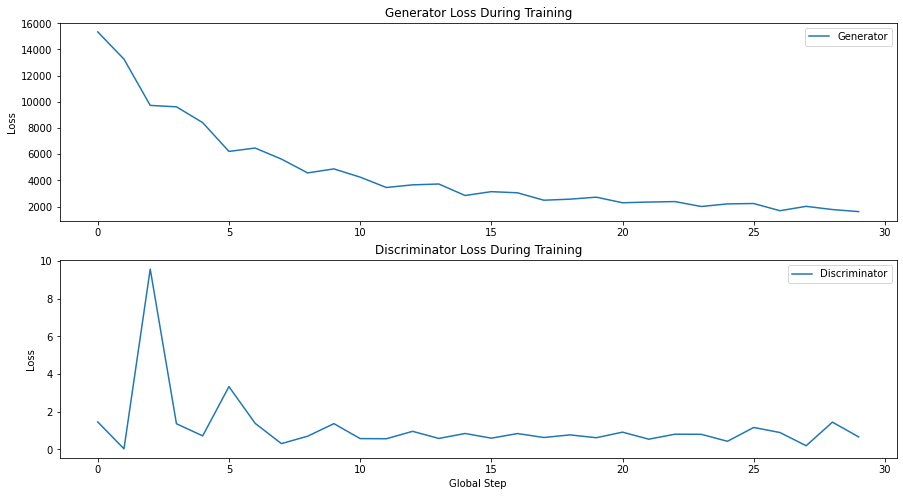

In [34]:
# training loss plot
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.title('Generator Loss During Training')
plt.plot(G_LOSS,label='Generator')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.title('Discriminator Loss During Training')
plt.plot(D_LOSS,label='Discriminator')
plt.xlabel('Global Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# # training nmse plot
# plt.figure(figsize=(5,10))
# plt.subplot(3,1,1)
# plt.title('NMSE During Training')
# plt.plot(NMSE_training, label='NMSE')
# plt.ylabel('NMSE')
# plt.legend()
# # training ssim plot
# plt.subplot(3,1,2)
# plt.title('SSIM During Training')
# plt.plot(SSIM_training, label='SSIM')
# plt.ylabel('SSIM')
# plt.legend()
# # training psnr plot
# plt.subplot(3,1,3)
# plt.title('PSNR During Training')
# plt.plot(PSNR_training, label='PSNR')
# plt.xlabel('Epoch')
# plt.ylabel('PSNR')
# plt.legend()
# plt.show()

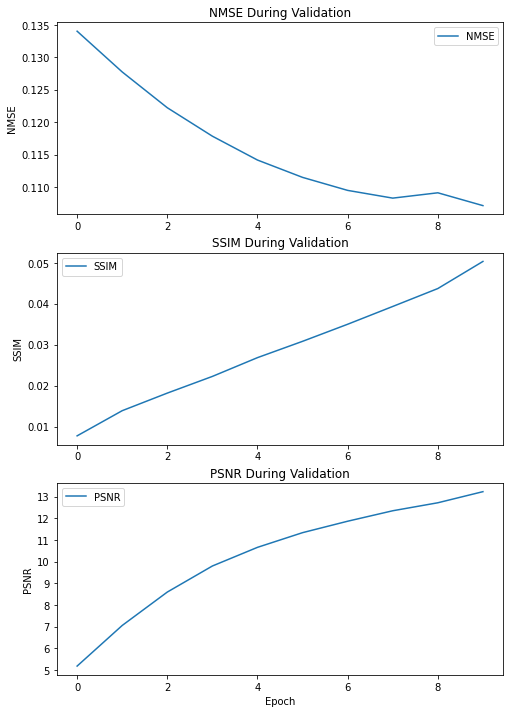

In [36]:
# validation nmse plot
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.title('NMSE During Validation')
plt.plot(NMSE_validation, label='NMSE')
plt.ylabel('NMSE')
plt.legend()
# validation ssim plot
plt.subplot(3,1,2)
plt.title('SSIM During Validation')
plt.plot(SSIM_validation, label='SSIM')
plt.ylabel('SSIM')
plt.legend()
# validation psnr plot
plt.subplot(3,1,3)
plt.title('PSNR During Validation')
plt.plot(PSNR_validation, label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

In [37]:
#testing
weight_unet = early_stopping.get_best_weight()

# reload unet
generator = UNet()
generator = generator.to(device)
generator.load_state_dict(torch.load(os.path.join(checkpoint_dir, weight_unet)))

# initialize testing
total_nmse_test = 0
total_ssim_test = 0
total_psnr_test = 0
num_test_temp = 0

X_good_test_sample = []
X_bad_test_sample = []
X_generated_test_sample = []

with torch.no_grad():
    # testing
    for step, X_good in enumerate(dataloader_test):

        # good-->bad
        X_bad = torch.from_numpy(to_bad_img(X_good.numpy(), mask))

        # cpu-->gpu
        X_good = X_good.to(device)
        X_bad = X_bad.to(device)

        # (N, H, W, C)-->(N, C, H, W)
        X_good = X_good.permute(0, 3, 1, 2)
        X_bad = X_bad.permute(0, 3, 1, 2)

        # generator
        if model_name == 'unet':
            X_generated = generator(X_bad, is_refine=False)
        elif model_name == 'unet_refine':
            X_generated = generator(X_bad, is_refine=True)
        else:
            raise Exception("unknown model")

        # gpu --> cpu
        X_good = X_good.cpu()
        X_generated = X_generated.cpu()
        X_bad = X_bad.cpu()

        # (-1,1)-->(0,1)
        X_good_0_1 = torch.div(torch.add(X_good, torch.ones_like(X_good)), 2)
        X_generated_0_1 = torch.div(torch.add(X_generated, torch.ones_like(X_generated)), 2)
        X_bad_0_1 = torch.div(torch.add(X_bad, torch.ones_like(X_bad)), 2)

        # eval for validation
        nmse_a = mse(X_generated_0_1, X_good_0_1)
        nmse_b = mse(X_generated_0_1, torch.zeros_like(X_generated_0_1))
        nmsn_res = torch.div(nmse_a, nmse_b).numpy()
        ssim_res = ssim(X_generated_0_1, X_good_0_1)
        psnr_res = psnr(X_generated_0_1, X_good_0_1)

        total_nmse_test = total_nmse_test + np.sum(nmsn_res)
        total_ssim_test = total_ssim_test + np.sum(ssim_res)
        total_psnr_test = total_psnr_test + np.sum(psnr_res)

        num_test_temp = num_test_temp + batch_size

        # output the sample
        X_good_test_sample.append(X_good_0_1[0, :, :, :])
        X_generated_test_sample.append(X_generated_0_1[0, :, :, :])
        X_bad_test_sample.append(X_bad_0_1[0, :, :, :])

    total_nmse_test = total_nmse_test / num_test_temp
    total_ssim_test = total_ssim_test / num_test_temp
    total_psnr_test = total_psnr_test / num_test_temp

    log = "NMSE testing average: {:8}\nSSIM testing average: {:8}\nPSNR testing average: {:8}\n\n".format(
        total_nmse_test, total_ssim_test, total_psnr_test)
    print(log)

C:\Users\H\.conda\envs\DAGAN_PyTorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys
C:\Users\H\.conda\envs\DAGAN_PyTorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  import sys


NMSE testing average: 0.07156987532824773
SSIM testing average: 0.10658228761955499
PSNR testing average: 12.16469930395927




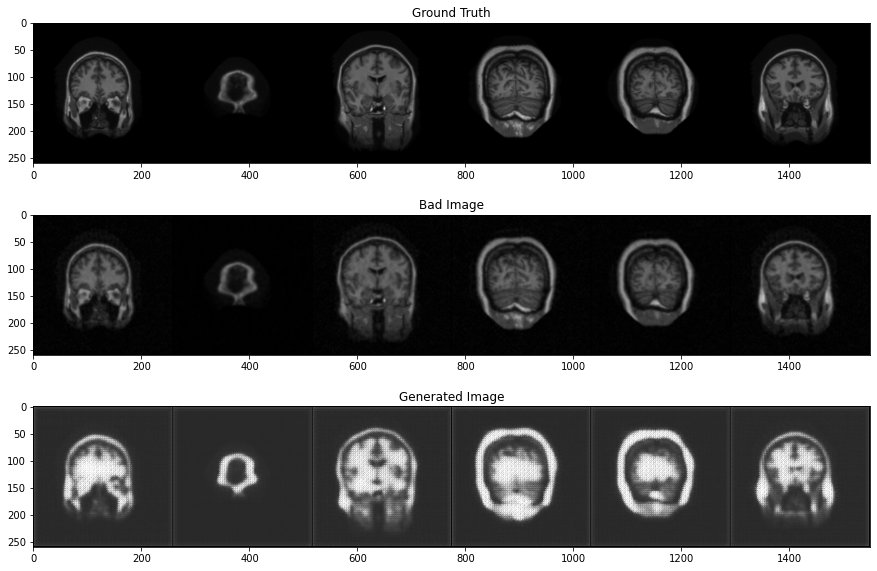

In [38]:
    # result
    selected_index = np.random.randint(len(X_good_test_sample), size=6)
    X_good_test_sample = torch.stack([X_good_test_sample[i] for i in selected_index])
    X_generated_test_sample = torch.stack([X_generated_test_sample[i] for i in selected_index])
    X_bad_test_sample = torch.stack([X_bad_test_sample[i] for i in selected_index])

    fig = plt.figure(figsize=(15,10))
    plt.axis('off')

    fig.add_subplot(3,1,1)
    plt.title('Ground Truth')
    img = np.transpose(vutils.make_grid(X_good_test_sample, padding=2,  nrow=6),(1,2,0))
    plt.imshow(img)

    fig.add_subplot(3,1,2)
    plt.title('Bad Image')
    img = np.transpose(vutils.make_grid(X_bad_test_sample, padding=2,  nrow=6),(1,2,0))
    plt.imshow(img)

    fig.add_subplot(3,1,3)
    plt.title('Generated Image')
    img = np.transpose(vutils.make_grid(X_generated_test_sample, padding=2,  nrow=6),(1,2,0))
    plt.imshow(img)
    plt.show()
